In [1]:
#import json

import pandas as pd
import altair as alt
#from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline
#from sklearn.cluster import KMeans
#from sklearn.preprocessing import Normalizer
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import scale

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable('mimetype')
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

In [2]:
# load data
boardgame_data = pd.read_csv('board_games.csv', parse_dates=['year_published'])
boardgame_data['year_published'] = pd.to_datetime(boardgame_data['year_published'], format='%Y')

In [3]:
# convert NA values for these features to a value
values = {'category': 'None', 'family': 'None', 'mechanic': 'None', 'publisher': 'None'}
boardgame_data.fillna(value = values, inplace = True)
# convert multi-values to lists
column_list = ['category', 'mechanic', 'family', 'publisher']
boardgame_data[column_list] = boardgame_data[column_list].apply(lambda x: x.str.split(","))

In [4]:
boardgame_data.head()

,game_id,description,image,max_players,max_playtime,min_age,min_players,min_playtime,name,playing_time,...,artist,category,compilation,designer,expansion,family,mechanic,publisher,average_rating,users_rated
0,1,Die Macher is a game about seven sequential po...,//cf.geekdo-images.com/images/pic159509.jpg,5,240,14,3,240,Die Macher,240,...,Marcus Gschwendtner,"[Economic, Negotiation, Political]",NaN,Karl-Heinz Schmiel,NaN,"[Country: Germany, Valley Games Classic Line]","[Area Control / Area Influence, Auction/Biddin...","[Hans im Glück Verlags-GmbH, Moskito Spiele, V...",7.66508,4498
1,2,Dragonmaster is a trick-taking card game based...,//cf.geekdo-images.com/images/pic184174.jpg,4,30,12,3,30,Dragonmaster,30,...,Bob Pepper,"[Card Game, Fantasy]",NaN,"G. W. ""Jerry"" D'Arcey",NaN,[Animals: Dragons],[Trick-taking],"[E.S. Lowe, Milton Bradley]",6.60815,478
2,3,"Part of the Knizia tile-laying trilogy, Samura...",//cf.geekdo-images.com/images/pic3211873.jpg,4,60,10,2,30,Samurai,60,...,Franz Vohwinkel,"[Abstract Strategy, Medieval]",NaN,Reiner Knizia,NaN,"[Asian Theme, Country: Japan, Knizia tile-layi...","[Area Control / Area Influence, Hand Managemen...","[999 Games, ABACUSSPIELE, Astrel Games, Ceilik...",7.44119,12019
3,4,When you see the triangular box and the luxuri...,//cf.geekdo-images.com/images/pic285299.jpg,4,60,12,2,60,Tal der Könige,60,...,NaN,[Ancient],NaN,Christian Beierer,NaN,"[Country: Egypt, Promotional Board Games]","[Action Point Allowance System, Area Control /...",[KOSMOS],6.60675,314
4,5,"In Acquire, each player strategically invests ...",//cf.geekdo-images.com/images/pic342163.jpg,6,90,12,3,90,Acquire,90,...,"Scott Okumura,Peter Whitley",[Economic],NaN,Sid Sackson,NaN,[3M Bookshelf Series],"[Hand Management, Stock Holding, Tile Placement]","[3M, Avalon Hill, Avalon Hill (Hasbro), Dujard...",7.35830,15195


In [5]:
# create subset of data features
# note that 'family' is not currently included due to the high number of values (creates a very large matrix when)
boardgame_data_sub = boardgame_data.copy()
boardgame_data_sub = boardgame_data_sub[['game_id', 'name', 'category', 'compilation', 'expansion', 
                                         'mechanic', 'average_rating', 'users_rated']]

# these feastures may be added in later (all numeric)
                                        # 'max_players', 'max_playtime', 'min_age', 'min_players', 
                                        # 'min_playtime', 'playing_time']]

In [6]:
boardgame_data_sub.head()

,game_id,name,category,compilation,expansion,mechanic,average_rating,users_rated
0,1,Die Macher,"[Economic, Negotiation, Political]",NaN,NaN,"[Area Control / Area Influence, Auction/Biddin...",7.66508,4498
1,2,Dragonmaster,"[Card Game, Fantasy]",NaN,NaN,[Trick-taking],6.60815,478
2,3,Samurai,"[Abstract Strategy, Medieval]",NaN,NaN,"[Area Control / Area Influence, Hand Managemen...",7.44119,12019
3,4,Tal der Könige,[Ancient],NaN,NaN,"[Action Point Allowance System, Area Control /...",6.60675,314
4,5,Acquire,[Economic],NaN,NaN,"[Hand Management, Stock Holding, Tile Placement]",7.35830,15195


In [7]:
# compilation and expansion have a high number of values and many boardgames don't have any values at all
# just list whether a game is part of a compilation or expanionsion or not (1, 0) encoding
boardgame_data_sub[['expansion', 'compilation']] = boardgame_data_sub[['expansion', 'compilation']].notna()
boardgame_data_sub.expansion = boardgame_data_sub.expansion.astype(int)
boardgame_data_sub.compilation = boardgame_data_sub.compilation.astype(int)

In [8]:
# check that dataset is complete
boardgame_data_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10532 entries, 0 to 10531
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   game_id         10532 non-null  int64  
 1   name            10532 non-null  object 
 2   category        10532 non-null  object 
 3   compilation     10532 non-null  int32  
 4   expansion       10532 non-null  int32  
 5   mechanic        10532 non-null  object 
 6   average_rating  10532 non-null  float64
 7   users_rated     10532 non-null  int64  
dtypes: float64(1), int32(2), int64(2), object(3)
memory usage: 576.1+ KB


In [9]:
# convert category and mechanic to one hot encoding and standardize the columns
binarizer = MultiLabelBinarizer()
category = pd.DataFrame(scale(binarizer.fit_transform(boardgame_data_sub.category)), columns = binarizer.classes_)
binarizer = MultiLabelBinarizer()
mechanic = pd.DataFrame(scale(binarizer.fit_transform(boardgame_data_sub.mechanic)), columns = binarizer.classes_)

onehot_df = pd.concat([category, mechanic], axis = 1)
onehot_df

# standardize numeric user rating categories 
user_scaled = pd.DataFrame(scale(boardgame_data_sub[['average_rating', 'users_rated']]), columns = ['average_rating', 'users_rated'])


In [10]:
# run T-SNE on one-hot encoding category features
tsne_cat = TSNE(n_components=2)
tsne_cat_results = tsne_cat.fit_transform(onehot_df)
# run-TSNE on user ratings features
tsne_user  = TSNE(n_components=1)
tsne_user_results = tsne_user.fit_transform(user_scaled)

In [22]:
# create a dataframe for plotting and output
tsne_cat_df = pd.DataFrame(tsne_cat_results, columns = ['x', 'y'])
# note: dividing user tsne results by 2 for plotting purposes
tsne_user_df = pd.DataFrame(tsne_user_results/2, columns = ['z'])
combined_output = pd.concat([tsne_cat_df, 
                                tsne_user_df, 
                                boardgame_data_sub], axis = 1)

In [23]:
# labeller helper for caetgories
def highlighter(x, labels):
    for label in labels:
        if (label in x): return label
    return 'none'

In [24]:
combined_output['highlight'] = combined_output.category.map(lambda x: highlighter(x, ['Economic', 'Vietnam War', 'Science Fiction', 'Fantasy']))

In [25]:
combined_output.highlight.unique()

array(['Economic', 'Fantasy', 'none', 'Science Fiction', 'Vietnam War'],
      dtype=object)

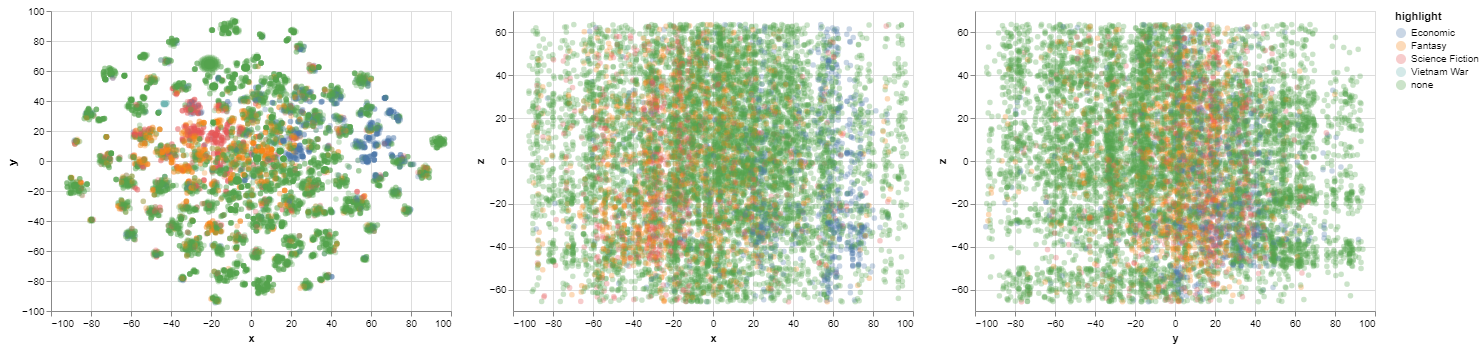

In [28]:
first = (alt.Chart(combined_output).mark_circle(opacity=0.3).encode(
    alt.X('x'),
    alt.Y('y'),
    alt.Color('highlight')))

second = (alt.Chart(combined_output).mark_circle(opacity=0.3).encode(
    alt.X('x'),
    alt.Y('z'),
    alt.Color('highlight')))

third = (alt.Chart(combined_output).mark_circle(opacity=0.3).encode(
    alt.X('y'),
    alt.Y('z'),
    alt.Color('highlight')))

first | second | third

In [29]:
combined_output.to_csv('nodes.csv', index=False)

In [209]:
import plotly.graph_objs as go

In [152]:
# testing plotly inputs
tsne_df = pd.read_csv("nodes.csv")

data = []
for idx, val in tsne_df.groupby(tsne_df.highlight):
    if idx == "none":
        continue
    highlight = idx

    scatter = go.Scatter3d(
        name=f"Class {highlight}",
        x=val["x"],
        y=val["y"],
        z=val["z"],
        mode="markers",
        marker=dict(size=2.5, symbol="circle-open"),
    )
    data.append(scatter)

In [ ]:
# scratch work below when trying to get a pipeline to work
# ignore for now

In [99]:
t = [('num', Normalizer('l1'), num_cols)]
col_transform = ColumnTransformer(transformers = t)

In [100]:
model = KMeans(n_clusters = 10, n_init = 1000)

In [101]:
pipeline = Pipeline(steps=[('prep', col_transform), ('m', model)])

In [102]:
pipeline

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', Normalizer(norm='l1'),
                                                  ['average_rating',
                                                   'users_rated'])])),
                ('m', KMeans(n_clusters=10, n_init=1000))])